**Libraries**

In [2]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

**Preprocessing**

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_folder = "mri_brain_tumor"

train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

In [12]:
def compute_mean_std(loader):
    mean = torch.zeros(3) # init mean for 3 channels
    std = torch.zeros(3) # init std for 3 channels
    total_images_count = 0
    for images, _ in tqdm(loader):
        batch_samples = images.size(0) # batch size
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    
    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = compute_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 714/714 [00:25<00:00, 28.49it/s]

Mean: tensor([0.1855, 0.1855, 0.1855])
Std: tensor([0.1813, 0.1813, 0.1813])


In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

**Dataset exploration**

In [16]:
print(">>> IMAGES <<<")
print(f"{len(train_loader.dataset)} train images")
print(f"{len(test_loader.dataset)} test images")
print()

print(">>> LABELS <<<")
print(train_dataset.class_to_idx)

>>> IMAGES <<<
5712 train images
1311 test images

>>> LABELS <<<
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [35]:
def plot_statistics(dataloader, title):
    all_labels = []
    for _, labels in tqdm(dataloader):
        all_labels.extend(labels.numpy())
    label_counts = Counter(all_labels)
    class_names = dataloader.dataset.classes

    labels, counts = zip(*label_counts.items())
    plt.figure(figsize=[6, 3])
    plt.bar(labels, counts, tick_label=[class_names[i] for i in labels], width=0.4)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Label distribution in {title}")
    plt.grid(axis='y')
    plt.show()

100%|██████████| 714/714 [00:18<00:00, 37.74it/s]


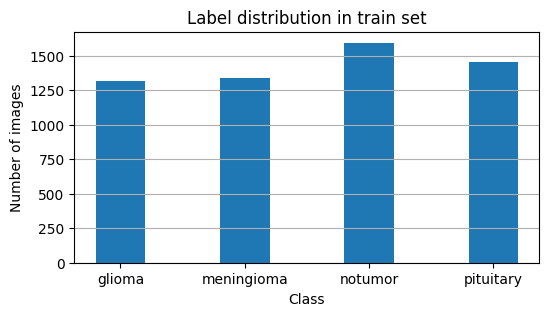

100%|██████████| 164/164 [00:06<00:00, 27.00it/s]


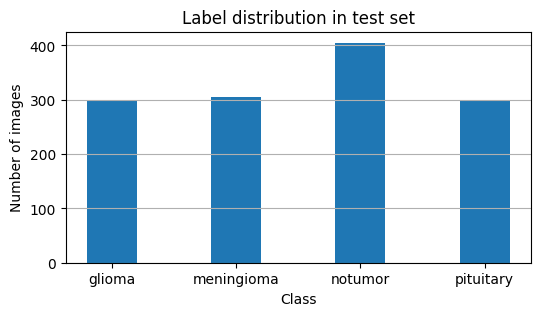

In [36]:
plot_statistics(train_loader, title="train set")
plot_statistics(test_loader, title="test set")

Info
- images are fetched in batches of dimensionality `[8, 3, 224, 224]`
- classes: `[0: glioma, 1: meningioma, 2: notumor, 3: pituitary]`

In [7]:
for batch in train_loader:
    print(batch[1])
    break

tensor([3, 2, 3, 1, 2, 1, 3, 2])


**Neural Network**

In [22]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()

        # Conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # FC layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, x):
        # conv, batch norm, relu, pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # flattening
        x = x.view(-1, 128 * 28 * 28)
        
        # fc layers, relu
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [23]:
model = CNN(num_classes=4)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 51476484


**Loss and Optimizer**

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

**Training the model**

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [34]:
def train(dataloader, model, device, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        for batch_idx, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if batch_idx % 64 == 0:
                print(f"[{batch_idx}/{len(dataloader)}]")
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

    print("Training complete.")

In [35]:
train(train_loader, model, device, num_epochs=1)

Epoch [1/1]
[0/714]
[64/714]
[128/714]
[192/714]
[256/714]
[320/714]
[384/714]
[448/714]
[512/714]
[576/714]
[640/714]
[704/714]
Epoch [1/1], Loss: 0.2104
Training complete.


In [53]:
# Save/Load weights
model_save_path = "weights/cnn.pth"

# Save
#torch.save(model.state_dict(), model_save_path)

# Load
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

**Test the model**

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def test(model, device, dataloader):
    print('Testing started.')
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print('Testing completed.')
    return all_labels, all_preds

all_labels, all_preds = test(model, device, test_loader)

Testing started.


100%|██████████| 164/164 [00:12<00:00, 13.60it/s]

Testing completed.


**Performance on unseen data**

In [55]:
def metrics_macro(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return precision, recall, f1

def metrics_per_class(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)

    return precision, recall, f1


In [56]:
precision, recall, f1 = metrics_macro(all_labels, all_preds)

print(f"Overall Precision: \t{precision:.4f}")
print(f"Overall Recall: \t{recall:.4f}")
print(f"Overall F1 Score: \t{f1:.4f}")

Overall Precision: 	0.9200
Overall Recall: 	0.9173
Overall F1 Score: 	0.9177


In [57]:
precision_per_class, recall_per_class, f1_per_class = metrics_per_class(all_labels, all_preds)
class_names = train_loader.dataset.classes

print("\nPrecision per class:")
for i, p in enumerate(precision_per_class):
    print(f"\t{class_names[i]}: \t{p:.4f}")

print("\nRecall per class:")
for i, r in enumerate(recall_per_class):
    print(f"\t{class_names[i]}: \t{r:.4f}")

print("\nF1 Score per class:")
for i, f in enumerate(f1_per_class):
    print(f"\t{class_names[i]}: \t{f:.4f}")


Precision per class:
	glioma: 	0.9017
	meningioma: 	0.8942
	notumor: 	0.9416
	pituitary: 	0.9427

Recall per class:
	glioma: 	0.8867
	meningioma: 	0.8007
	notumor: 	0.9951
	pituitary: 	0.9867

F1 Score per class:
	glioma: 	0.8941
	meningioma: 	0.8448
	notumor: 	0.9676
	pituitary: 	0.9642
